In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import geopandas as gpd
from fiona.crs import from_epsg
%matplotlib inline

In [2]:
#load shape census tracts from:
#http://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyct2010_16d.zip
shape_path = 'data/nyct2010_16d/nyct2010.shp'
nyc = gpd.GeoDataFrame.from_file(shape_path)
nyc.index=nyc.BoroCT2010
nyc.head()

,BoroCT2010,BoroCode,BoroName,CDEligibil,CT2010,CTLabel,NTACode,NTAName,PUMA,Shape_Area,Shape_Leng,geometry
BoroCT2010,,,,,,,,,,,,
5000900,5000900,5,Staten Island,I,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016794,"POLYGON ((962269.1260375977 173705.5001831055,..."
5007400,5007400,5,Staten Island,I,007400,74,SI14,Grasmere-Arrochar-Ft. Wadsworth,3902,5.788238e+06,9902.948473,"POLYGON ((967656.8290405273 155637.1314086914,..."
1009800,1009800,1,Manhattan,I,009800,98,MN19,Turtle Bay-East Midtown,3808,1.906016e+06,5534.199811,"POLYGON ((994133.507019043 214848.8975830078, ..."
1010000,1010000,1,Manhattan,I,010000,100,MN19,Turtle Bay-East Midtown,3808,1.860938e+06,5692.168737,"POLYGON ((993108.3057861328 216013.1307983398,..."
1010200,1010200,1,Manhattan,I,010200,102,MN17,Midtown-Midtown South,3807,1.860993e+06,5687.802439,"POLYGON ((992216.5391845703 216507.6870117188,..."


In [3]:
#Coordinates
#original projection 
#http://www1.nyc.gov/assets/planning/download/pdf/data-maps/open-data/nyct2010_metadata.pdf?ver=16d
# epsg=4326: lat/on | 26918: NAD83/UTM zone 18N | epsg=2263 is US feet

nyc.crs = from_epsg(2263)


# if I wanted to change:
#NYC_Area=nyc.to_crs(epsg=2263).geometry.area.sum()/(2.788*10**7) # from ft2 to mi2 
#print 'total NYC land area: %s (mi^2)'%str(NYC_Area)[:5] # from ft2 to mi2 #epsg=2263 is US feet
print nyc.geometry.area.sum()
print nyc.Shape_Area.sum()

8429405956.99
8429401849.22


In [4]:
#download population data
nycPopulation=pd.read_csv('https://data.cityofnewyork.us/api/views/si4q-zuzm/rows.csv?accessType=DOWNLOAD',
                         dtype = {'Borough':unicode,'Year':int,'FIPS County Code':unicode,
                                 'DCP Borough Code':unicode,'Census Tract':unicode, 'Population':int})
nycPopulation['BoroCT2010'] = nycPopulation['DCP Borough Code'] + nycPopulation['Census Tract']
nycPopulation['BoroCT2010'] = nycPopulation['BoroCT2010'].astype(unicode)
nycPopulation.index = nycPopulation.BoroCT2010
nycPopulation.head()

,Borough,Year,FIPS County Code,DCP Borough Code,Census Tract,Population,BoroCT2010
BoroCT2010,,,,,,,
2000100,Bronx,2010,005,2,000100,11091,2000100
2000200,Bronx,2010,005,2,000200,4334,2000200
2000400,Bronx,2010,005,2,000400,5503,2000400
2001600,Bronx,2010,005,2,001600,5643,2001600
2001900,Bronx,2010,005,2,001900,1917,2001900


In [5]:
#nyc.loc[nyc.BoroName=='Bronx',:].head()

In [6]:
type(nycPopulation['BoroCT2010'][0])

unicode

In [7]:
type(nyc['BoroCT2010'][0])

unicode

In [8]:
nyc.BoroCT2010.isin(nycPopulation['BoroCT2010']).sum()

2166

In [9]:
nyc = nyc.merge(nycPopulation.loc[:,['BoroCT2010','Population']],on='BoroCT2010')
nyc.head()

,BoroCT2010,BoroCode,BoroName,CDEligibil,CT2010,CTLabel,NTACode,NTAName,PUMA,Shape_Area,Shape_Leng,geometry,Population
0,5000900,5,Staten Island,I,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016794,"POLYGON ((962269.1260375977 173705.5001831055,...",2112
1,5007400,5,Staten Island,I,007400,74,SI14,Grasmere-Arrochar-Ft. Wadsworth,3902,5.788238e+06,9902.948473,"POLYGON ((967656.8290405273 155637.1314086914,...",4693
2,1009800,1,Manhattan,I,009800,98,MN19,Turtle Bay-East Midtown,3808,1.906016e+06,5534.199811,"POLYGON ((994133.507019043 214848.8975830078, ...",7316
3,1010000,1,Manhattan,I,010000,100,MN19,Turtle Bay-East Midtown,3808,1.860938e+06,5692.168737,"POLYGON ((993108.3057861328 216013.1307983398,...",1992
4,1010200,1,Manhattan,I,010200,102,MN17,Midtown-Midtown South,3807,1.860993e+06,5687.802439,"POLYGON ((992216.5391845703 216507.6870117188,...",230


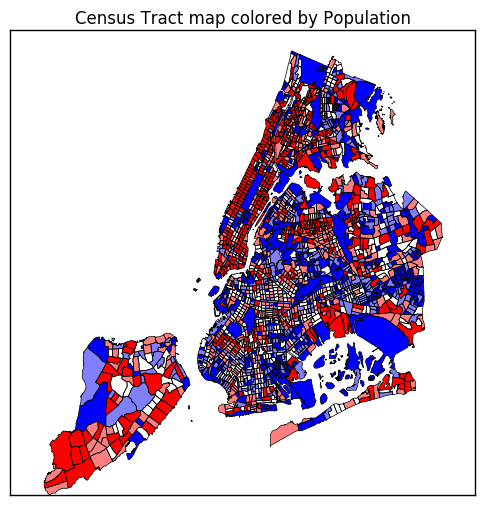

In [10]:
#PLOTING USING QUANTILES
f, ax = plt.subplots(figsize=(6,6))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
nyc.plot(column='Population',
         alpha=1,
         linewidth=0.5,
         ax=ax,
         cmap = 'bwr',
         scheme='QUANTILES', #QUANTILES o fisher_jenks
)
plt.title("Census Tract map colored by Population")

In [11]:
#Download subway entrances 
# 'https://data.cityofnewyork.us/api/geospatial/drex-xx56?method=export&format=Shapefile'
subwayPath = '/home/pipe/projects/ads/data/Subway Entrances/geo_export_35046f7e-f5ca-4a0a-bafe-cc0ef943d335.shp'
subwayEntrances = gpd.GeoDataFrame.from_file(subwayPath)
subwayEntrances.head()

,geometry,line,name,objectid,url
0,POINT (-73.86835600032798 40.84916900104506),2-5,Birchall Ave & Sagamore St at NW corner,1734.0,http://web.mta.info/nyct/service/
1,POINT (-73.86821300022677 40.84912800131844),2-5,Birchall Ave & Sagamore St at NE corner,1735.0,http://web.mta.info/nyct/service/
2,POINT (-73.87349900050798 40.84122300105249),2-5,Morris Park Ave & 180th St at NW corner,1736.0,http://web.mta.info/nyct/service/
3,POINT (-73.87289199978331 40.84145300067447),2-5,Morris Park Ave & 180th St at NW corner,1737.0,http://web.mta.info/nyct/service/
4,POINT (-73.87962300013866 40.84081500075867),2-5,Boston Rd & 178th St at SW corner,1738.0,http://web.mta.info/nyct/service/


In [12]:
print 'subway crs', subwayEntrances.crs
print 'nyc crs', nyc.crs

subwayEntrances.crs = from_epsg(4326)
subwayEntrances = subwayEntrances.to_crs(epsg=2263)

print 'subway crs', subwayEntrances.crs


subway crs {'init': u'epsg:4326'}
nyc crs {'init': 'epsg:2263', 'no_defs': True}
subway crs {'init': 'epsg:2263', 'no_defs': True}


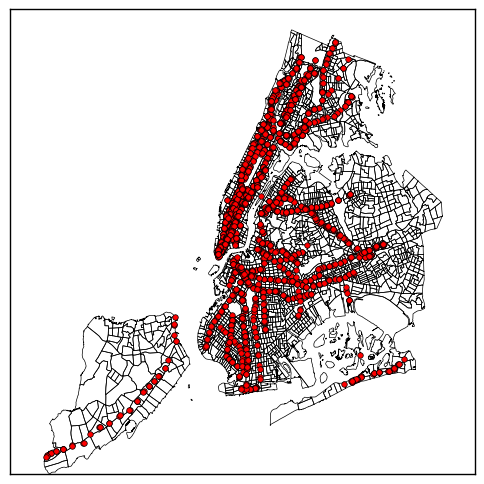

In [13]:
f, ax = plt.subplots(figsize=(6,6))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

nyc.plot(alpha=.2,
         linewidth=0.5,
         ax=ax,color='white')
subwayEntrances.plot(column = 'line',
            marker='o', color='red', markersize=4,
         alpha=1,
         linewidth=0.1,
         ax=ax)


In [14]:
#buffers
#http://geopandas.org/geometric_manipulations.html?highlight=buffer
#subwayEntrances.crs is 2263 in US feet. 
#Walkable distance is 1/4 mi
#http://humantransit.org/2011/04/basics-walking-distance-to-transit.html

print subwayEntrances.crs

walkableDistance = 5280/4.
walkableDistance

{'init': 'epsg:2263', 'no_defs': True}


1320.0

In [15]:
#create a buffer around all subway entrances
walkableToSubway = subwayEntrances.buffer(walkableDistance)


In [16]:
walkableToSubway = walkableToSubway.to_frame(name='geometry')
walkableToSubway['city'] = 'nyc'
walkableToSubway = gpd.GeoDataFrame(walkableToSubway, crs=2263, geometry='geometry')

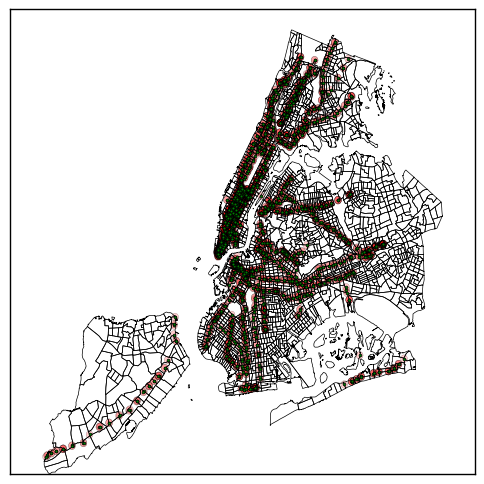

In [17]:
f, ax = plt.subplots(figsize=(6,6))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

nyc.plot(alpha=.2,
         linewidth=0.5,
         ax=ax,color='white')
walkableToSubway.plot(color='red',
         alpha=.2,
         linewidth=0.1,
         ax=ax)
subwayEntrances.plot( color='green',
         alpha=1,
         linewidth=0.1,
         ax=ax)

In [18]:
#dissolve all buffers into one:
#http://geopandas.org/aggregation_with_dissolve.html
walkableToSubwayDiss = walkableToSubway.dissolve(by = 'city')
walkableToSubwayDiss

,geometry
city,
nyc,"(POLYGON ((932111.930067223 133595.5812840766,..."


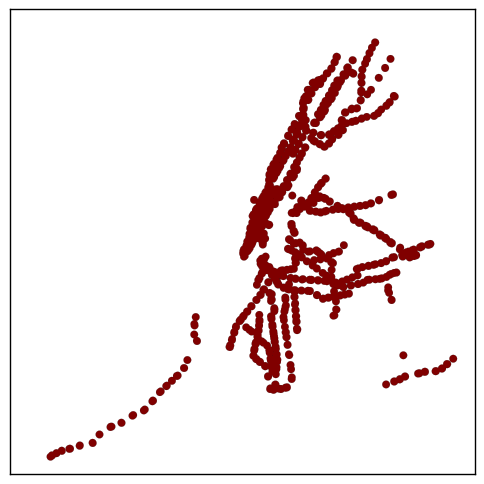

In [19]:
f, ax = plt.subplots(figsize=(6,6))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

walkableToSubwayDiss.plot(alpha=1,
         linewidth=0.1,
         ax=ax)

In [20]:
#create buffer for bikeable distance to a subway entraance, 1 mile 5280 feet
bikeableToSubway = subwayEntrances.buffer(5280)
bikeableToSubway = bikeableToSubway.to_frame(name='geometry')
bikeableToSubway['city'] = 'nyc'
bikeableToSubway = gpd.GeoDataFrame(bikeableToSubway, crs=2263, geometry='geometry')
bikeableToSubwayDiss = bikeableToSubway.dissolve(by = 'city')


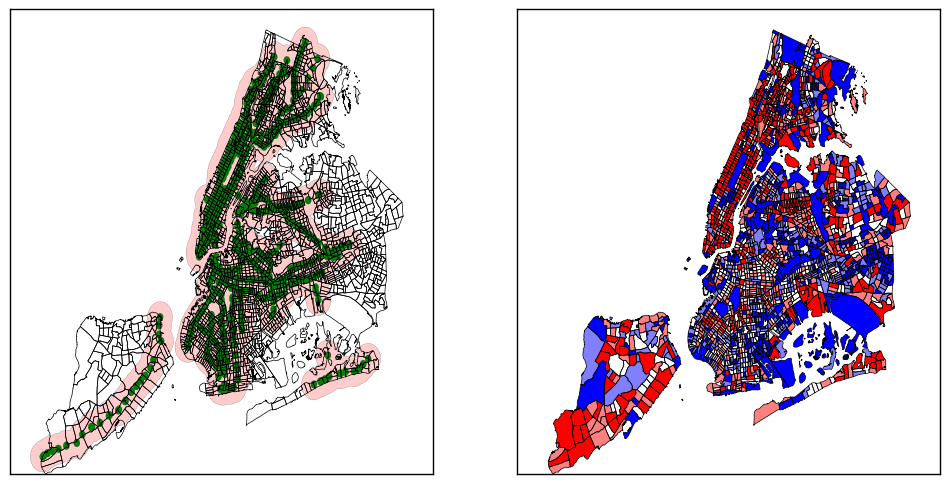

In [25]:
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)

nyc.plot(alpha=.2,
         linewidth=0.5,
         ax=ax1,color='white')
bikeableToSubwayDiss.plot(color='red',
         alpha=.2,
         linewidth=0.1,
         ax=ax1)
walkableToSubwayDiss.plot( color='green',
         alpha=1,
         linewidth=0.1,
         ax=ax1)

nyc.plot(column='Population',
         alpha=1,
         linewidth=0.5,
         ax=ax2,
         cmap = 'bwr',
         scheme='QUANTILES', #QUANTILES o fisher_jenks
)


In [27]:
union = gpd.overlay(nyc, bikeableToSubwayDiss, how='intersection')

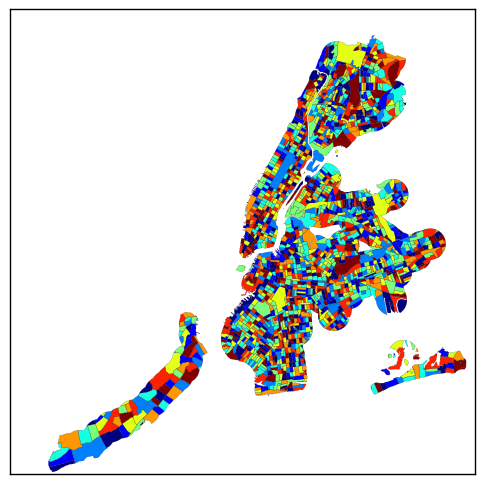

In [29]:
f, ax = plt.subplots(figsize=(6,6))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

union.plot(color = 'white',
           alpha=1,
         linewidth=0.1,
         ax=ax)

In [30]:
difference = gpd.overlay(union, walkableToSubwayDiss, how='difference')

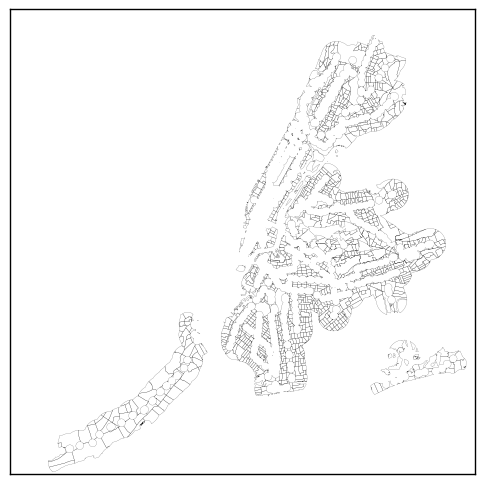

In [31]:
f, ax = plt.subplots(figsize=(6,6))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

difference.plot(color = 'white',
                alpha=1,
         linewidth=0.1,
         ax=ax)

In [32]:
difference.head()

,BoroCT2010,BoroCode,BoroName,CDEligibil,CT2010,CTLabel,NTACode,NTAName,PUMA,Shape_Area,Shape_Leng,Population,geometry
0,5024402,5,Staten Island,I,024402,244.02,SI11,Charleston-Richmond Valley-Tottenville,3901,1.927947e+07,22538.010296,4259,"POLYGON ((913546.3511962891 122322.2593994141,..."
1,5024401,5,Staten Island,I,024401,244.01,SI11,Charleston-Richmond Valley-Tottenville,3901,2.256168e+07,24582.825105,5823,"POLYGON ((913580.934387207 122397.0115966797, ..."
2,5024800,5,Staten Island,I,024800,248,SI11,Charleston-Richmond Valley-Tottenville,3901,1.758599e+07,31758.767682,4741,"POLYGON ((913281.4796142578 124378.4056396484,..."
3,5019800,5,Staten Island,I,019800,198,SI01,Annadale-Huguenot-Prince's Bay-Eltingville,3901,6.117169e+07,43906.900562,6300,"POLYGON ((922346.677415309 123688.5849272069, ..."
4,5022600,5,Staten Island,I,022600,226,SI11,Charleston-Richmond Valley-Tottenville,3901,8.624076e+07,54959.982674,8490,"POLYGON ((923683.9504514073 135082.6226862803,..."
